### Using Variational Autoencoder to Generate Digital Numbers

Variational Autoencoders (VAEs) are very popular approaches to unsupervised learning of complicated distributions. 

![Standard Autoencoder](./standard_autoencoder.jpg)

In standard Autoencoder, we have an encoder network that takes in the original image and encode it into a vector of latent variables and a decoder network that takes in the latent vector and output an generated image that we hope to look similar to the original image.

![vae](./vae.jpg)

In [1]:
#import packages
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt 
#BigDL packages
from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.dataset import mnist
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *
from bigdl.models.ml_pipeline.dl_classifier import *
#Import Analytic zoo
from zoo.pipeline.api.keras.layers import *
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.keras.utils import *
#PySpark 
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
#Creating spark context 
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","8g"))

init_engine()

/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7/, and pyspark is found in: /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)
/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zoo/util/engine.py:42: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7/, and pyspark is found in: /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, you are

Prepending /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [2]:
#Setting the path for Spark
os.environ['JAVA_HOME']="/usr/lib/jvm/java-8-oracle"
os.environ['SPARK_HOME'] = "/home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/kunal/Downloads/jarfiles/bigdl-SPARK_2.2-0.7.0-jar-with-dependencies.jar --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.3,org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.3 pyspark-shell'

In [3]:
#Creating Spark Session
from pyspark.context import SparkContext
# from pyspark.sql.session import SparkSession
#import pyspark packages
## Create SparkContext, SparkSession
import pyspark
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from zoo.common.nncontext import *
# sc = init_nncontext("Variational Autoencoder Example")
spark = SparkSession(sc)
sqlContext = SQLContext(sc)
spark.conf.set("spark.memory.offHeap.enabled",True)
spark.conf.set("spark.memory.offHeap.size",6442450944)

In [4]:
#Define parameters
IMAGE_SIZE = 784
IMAGE_ROWS = 28
IMAGE_COLS = 28
IMAGE_CHANNELS = 1
latent_size = 2

In [5]:
#Method for Encoder
def get_encoder(latent_size):
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_COLS, IMAGE_ROWS))
    
    #CONV
    conv1 = Convolution2D(16, 5, 5, input_shape=(IMAGE_CHANNELS, IMAGE_ROWS, IMAGE_COLS), border_mode='same',
                          subsample=(2, 2))(input0)
    relu1 = LeakyReLU()(conv1)
    conv2 = Convolution2D(32, 5, 5, input_shape=(16, 14, 14), border_mode='same', subsample=(2, 2))(relu1)
    relu2 = LeakyReLU()(conv2)  # 32,7,7
    reshape = Flatten()(relu2)
    
    #fully connected to output mean vector and log-variance vector
    reshape = Reshape([7*7*32])(relu2)
    z_mean = Dense(latent_size)(reshape)
    z_log_var = Dense(latent_size)(reshape)
    model = Model([input0],[z_mean,z_log_var])
    return model

In [6]:
#Decoding Method
def get_decoder(latent_size):
    input0 = Input(shape=(latent_size,))
    reshape0 = Dense(1568)(input0)
    reshape1 = Reshape((32, 7, 7))(reshape0)
    relu0 = Activation('relu')(reshape1)
    
    # use resize and conv layer instead of deconv layer
    resize1 = ResizeBilinear(14,14)(relu0)
    deconv1 = Convolution2D(16, 5, 5, subsample=(1, 1), activation='relu', border_mode = 'same', input_shape=(32, 14, 14))(resize1)
    resize2 = ResizeBilinear(28,28)(deconv1)
    deconv2 = Convolution2D(1, 5, 5, subsample=(1, 1), input_shape=(16, 28, 28), border_mode = 'same')(resize2)
    outputs = Activation('sigmoid')(deconv2)
    
    model = Model([input0],[outputs])
    return model

In [7]:
#Autoencoding Method
def get_autoencoder(latent_size):
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_COLS, IMAGE_ROWS))
    encoder = get_encoder(latent_size)(input0)
    sample = GaussianSampler()(encoder)
    decoder_model = get_decoder(latent_size)
    decoder = decoder_model(sample)
    model = Model([input0],[encoder,decoder])
    return model,decoder_model

In [8]:
autoencoder,decoder_model = get_autoencoder(2)

creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasLeakyReLU
creating: createZooKerasConvolution2D
creating: createZooKerasLeakyReLU
creating: createZooKerasFlatten
creating: createZooKerasReshape
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createZooKerasGaussianSampler
creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasReshape
creating: createZooKerasActivation
creating: createZooKerasResizeBilinear
creating: createZooKerasConvolution2D
creating: createZooKerasResizeBilinear
creating: createZooKerasConvolution2D
creating: createZooKerasActivation
creating: createZooKerasModel
creating: createZooKerasModel


In [9]:
#Getting MNIST Dataset
def get_mnist(sc, mnist_path):
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    train_images = np.reshape(train_images, (60000, 1, 28, 28))
    rdd_train_images = sc.parallelize(train_images)

    rdd_train_sample = rdd_train_images.map(lambda img:
                                        Sample.from_ndarray(
                                        (img > 128) * 1.0,
                                        [(img > 128) * 1.0, (img > 128) * 1.0]))
    return rdd_train_sample

In [10]:
mnist_path = "./data/mnist" # please replace this

train_data = get_mnist(sc, mnist_path)
# (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz


In [11]:
#Define our Training Objective
batch_size = 96
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 1.0)
criterion.add(BCECriterion(size_average=False), 1.0/batch_size)

creating: createParallelCriterion
creating: createKLDCriterion
creating: createBCECriterion


In [12]:
#Model compile
autoencoder.compile(optimizer=Adam(0.001), loss=criterion)

import os
if not os.path.exists("./log"):
    os.makedirs("./log")
                
app_name='vae-digits-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
autoencoder.set_tensorboard(log_dir='./log/',app_name=app_name)

print("Saving logs to ", app_name)

creating: createAdam
Saving logs to  vae-digits-20210129-114902


In [13]:
#Start Training
autoencoder.fit(x=train_data,
                batch_size=batch_size,
                nb_epoch = 10)

In [14]:
#Visualization on Tensorboard
%load_ext tensorboard
%tensorboard --logdir=./log/

In [15]:
#Visualization using matplotlib
import matplotlib
matplotlib.use('Agg')
%pylab inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/

creating: createTrainSummary


Text(0.5,1,'loss')

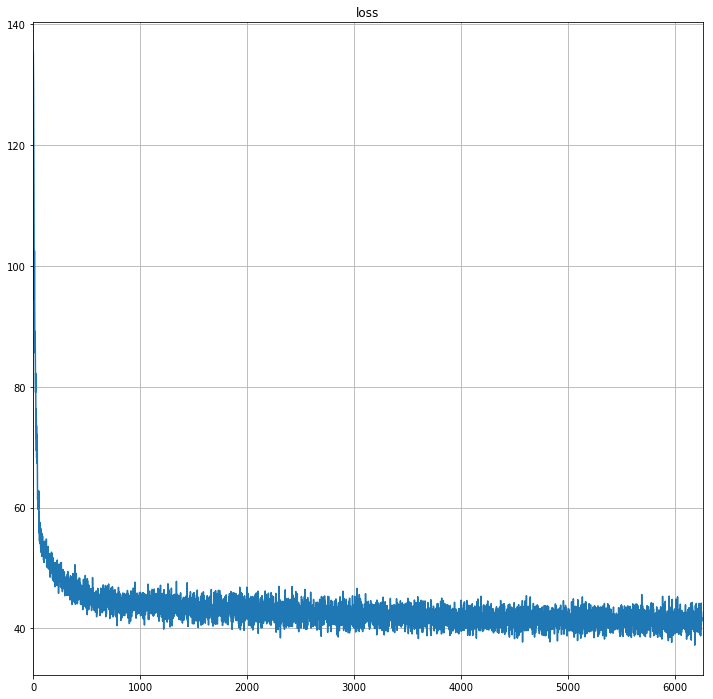

In [16]:
#Summary
train_summary = TrainSummary('./log/', app_name)
loss = np.array(train_summary.read_scalar("Loss"))
plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

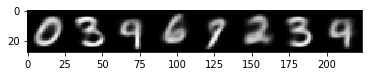

In [17]:
#Sample Some Images from the Decoder
from matplotlib.pyplot import imshow
img = np.column_stack([decoder_model.forward(np.random.randn(1,2)).reshape(28,28) for s in range(8)])
imshow(img, cmap='gray')

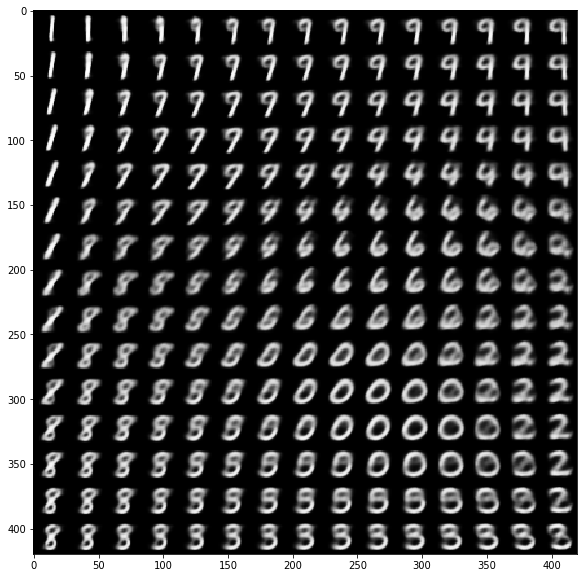

In [18]:
#Explore the Latent Space
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_model.forward(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()